# Capstone Project 1 - Part 1 Data Acquisition and Data Wrangling

## Title: Data Acquisition and Data Wrangling for later Prediction of electricity rates (cost/Kwh) and consumption
### Author: Elizabeth Izarra

### General Problem:
Electricity has a very dynamic market price since it is a commodity that is essential for daily life and 
non-storable where generation and demand must be continuously balanced. This is turn make it dependable of the 
weather conditions.    

### Data Sources:

- U.S. Energy Information Administration (EIA)
- National Oceanic and Atmospheric Administration NOAA

### Data Adquisition and Data Wrangling:
The data has to be gotten from different web sources. Each source provides APIs which have to be explored to get the required data for the project.

The data adquisition and data wrangling was divided in three parts:
   - U.S. Energy Information Administration (EIA): API Exploration, data acquisition and data wrangling in order to get a single view data set of electricity prices, demand, etc by state per month
     
         Findings:
         Each variable serie has to be independently fetched per State through APIs. 
     
         Approach:
         All the data by state corresponding to the same variable was fetched in a loop and concatenated adding  the state information. It was nested in a loop corresponding to all the variables of interest where after fetching each variable merged them in a single view. See In[7] and In[8]
         
         Sample Result:
         See Out[9]
     
   - National Oceanic and Atmospheric Adminostration (NOAA): API Exploration, data acquisition and data wrangling of data in order to get a single view data set of temperatures by state per month
   
         Findings:
         Global Monthly Summary series can be fetched per state through APIs. It provides summary data from each station at a state into a time range. Some states have around 350 stations. Nevertheless, the API maximum limit is 1000 records per fetch. 
        
         Approach:
         A couple of loops where nested to fetch data per state per month to cope with the fetching limit. The first loop was used to get the data from all the stations in a state in a month. It was then grouped by date and variables to get the mean of all the stations in the state during that month. The group was unstacked to be able to concatenate with the information of the following month while adding the corresponding state information. This was nested in a per-state loop. See In[18] and In[19]
         
         Sample Result:
         See out[20]
        

   - Merging EIA and NOAA Datasets
         
         The ISO3166 acronyms for US states with its correspondent states where searched and placed in a csv file. 

         On the NOAA temperature date set, a column with the corresponding ISO3166 codes was added, as well as, the date was formatted to “YYYY-MM-DD’.
         
         On the EIA data set, the date was formatted to “YYYY-MM-DD’

   


### ---------------------------------------------------------------------------------------------------

In [1]:
# import the relevant modules
import requests
from pandas.io.json import json_normalize
import pandas as pd
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns

### Source: U.S. Energy Information Administration (EIA)

In [2]:
def get_data_from_url(API_query):
    # Package the request, send the request and catch the response: r
    r=requests.get(API_query)

    # Inspect the JSON structure, and exploration of how nested it is,
    # as well as the overall structure

    # Decode the JSON data into a dictionary: json_data
    json_data=r.json()
    return json_data

In [3]:
API_KEY='a32b693a24d623394f601a1c4262fb10'

In [4]:
#Exploring the available variables
categoryID='0'
#Call the EIA API and pull out the data categories
url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
json_data=get_data_from_url(url)

In [5]:
#Getting the childcategories into a DataFrame
df_cat_IDs_0=json_normalize(json_data['category']['childcategories'])
df_cat_IDs_0

,category_id,name
0,1,Net generation
1,32,Total consumption (Btu)
2,33,Consumption for electricity generation (Btu)
3,34,Consumption for useful thermal output (Btu)
4,35,Total consumption
5,36,Consumption for electricity generation
6,37,Consumption for useful thermal output
7,38,Retail sales of electricity
8,39,Revenue from retail sales of electricity
9,40,Average retail price of electricity


In [6]:
    #Checking for childseries availability
    def childseries_check(cat_idx):
        categoryID=str(df_cat_IDs_0.iloc[cat_idx,0]) 
        

        ##API for series name exploration
        url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
        json_data=get_data_from_url(url)

        df_ser_ID=json_normalize(json_data['category']['childseries'])
        
        return(df_ser_ID)

In [7]:
#Getting series 

def get_series(idx, f, start, end):
       
        categoryID=str(df_cat_IDs_0.iloc[idx,0]) 
        variable=df_cat_IDs_0['name'][idx]

        #API for series name exploration
        url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
        json_data=get_data_from_url(url)

        df_ser_ID=json_normalize(json_data['category']['childseries'])

        #API for series name exploration
        url='http://api.eia.gov/category/?api_key='+API_KEY+'&category_id='+categoryID
        json_data=get_data_from_url(url)

        df_ser_ID=json_normalize(json_data['category']['childseries'])

        #getting the series ID for the monthly reporting per state
        #print(f, df_ser_ID.keys())
        ser_IDs=df_ser_ID[df_ser_ID['f'].str.contains(f)]

        #print(ser_IDs.head(), categoryID, variable) 

        #Getting series

        for i in range(len(ser_IDs)):
            #Building API
            seriesID=str(ser_IDs.iloc[i,2]) 
            url='http://api.eia.gov/series/?series_id='+seriesID+'&api_key='+API_KEY+'&start='+start+'&end='+end
            #Retriving data from URL
            json_data=get_data_from_url(url)
            #Extracting information of interest
            h1=json_normalize(json_data,['series'])
            h=json_normalize(json_data,['series',['data']])
           
            #try: print(h1['iso3166']) 
            #except: print('geography='+h1['geography'])
          
        
            #Adding names to columns
            h.columns=['date',variable]
            h['geography']=h1['geography']
            h['unit']=h1['units']
            try: h['iso3166']=h1['iso3166']
            except:h['iso3166']='N/A'
            
            #Chaging column positions
            g=pd.concat([h['date'],h['geography'],h['iso3166'], h[variable],h['unit']],axis=1)
            
            
            #Adding missing data
            g.fillna(method='ffill', inplace=True)
            #seriesID, json_data, g
            
            if i==0:
                df_data_cat=g
            else:

                df_data_cat=df_data_cat.append(g, ignore_index=True, sort=False)
        
        return df_data_cat

In [8]:
#Getting data from Energy Information Administration (EIA)


def get_eia_data(variables_idx, f,start, end):
    c_flag=0
    for idx in variables_idx:
        variable=df_cat_IDs_0['name'][idx]
        if  childseries_check(idx).empty:
            print(variable+' - does not have childseries available')
        else:    
            print(variable+' - OK')
            df_data_cat=get_series(idx, f, start, end)
            if c_flag==0:
                df_data=df_data_cat
                c_flag=1
            else:
            
                #Getting the data in a single view
                df_data=df_data.merge(df_data_cat, how='outer', left_on=['date','geography','iso3166'], 
                                      right_on=['date','geography','iso3166'])
    return df_data
    

#### Getting a Sample Data Set  from EIA for  2013

In [9]:
variables_idx=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18] #list of indexes of df_cat_IDs_0
f='M' #Frequency can be 'A':Annual, 'Q':Quarter or 'M':Monthly 
start='2013'
end='2013'
df_data=get_eia_data(variables_idx, f,start, end)
df_data.head()


Net generation - OK
Total consumption (Btu) - does not have childseries available
Consumption for electricity generation (Btu) - does not have childseries available
Consumption for useful thermal output (Btu) - does not have childseries available
Total consumption - does not have childseries available
Consumption for electricity generation - does not have childseries available
Consumption for useful thermal output - does not have childseries available
Retail sales of electricity - OK
Revenue from retail sales of electricity - OK
Average retail price of electricity - OK
Plant level data - does not have childseries available
Fossil-fuel stocks for electricity generation - does not have childseries available
Receipts of fossil fuels by electricity plants - does not have childseries available
Receipts of fossil fuels by electricity plants (Btu) - does not have childseries available
Average cost of fossil fuels for electricity generation - does not have childseries available
Average cost of

,date,geography,iso3166,Net generation,unit_x,Retail sales of electricity,unit_y,Revenue from retail sales of electricity,unit_x,Average retail price of electricity,unit_y,Number of customer accounts,unit
0,201312,USA-AK,USA-AK,649.50352,thousand megawatthours,602.36499,million kilowatthours,103.67788,million dollars,17.21,cents per kilowatthour,328186,number of customers
1,201311,USA-AK,USA-AK,564.70533,thousand megawatthours,526.26297,million kilowatthours,89.28706,million dollars,16.97,cents per kilowatthour,328614,number of customers
2,201310,USA-AK,USA-AK,568.77441,thousand megawatthours,504.66318,million kilowatthours,82.52414,million dollars,16.35,cents per kilowatthour,329670,number of customers
3,201309,USA-AK,USA-AK,503.93265,thousand megawatthours,487.79956,million kilowatthours,78.83753,million dollars,16.16,cents per kilowatthour,329133,number of customers
4,201308,USA-AK,USA-AK,499.43930,thousand megawatthours,503.01620,million kilowatthours,81.24433,million dollars,16.15,cents per kilowatthour,328807,number of customers


<function matplotlib.pyplot.show(*args, **kw)>

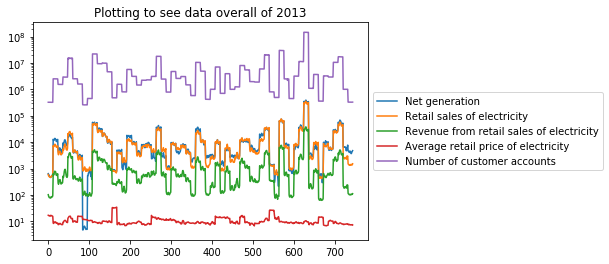

In [10]:
#Plotting to see data overall

plot1=df_data.plot(logy=True, title='Plotting to see data overall of 2013')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plot1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.show

### Source: National Oceanic and Atmospheric Administration NOAA

In [11]:
mytoken='AwkqwxasEbHFkzNhMJijIRrdkxVWSkBw'
token = {'token': mytoken}
token

{'token': 'AwkqwxasEbHFkzNhMJijIRrdkxVWSkBw'}

In [12]:
def get_data_from_NOAA(url):
    response = requests.get(url, headers = token) 
    json_data = response.json()
    return json_data

In [13]:
# Exploring all available datasets 
url='https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets'
json_data=get_data_from_NOAA(url)
b=json_normalize(json_data['results'])  
b#json_normalize(json_data['results'])


,datacoverage,id,maxdate,mindate,name,uid
0,1.00,GHCND,2019-04-15,1763-01-01,Daily Summaries,gov.noaa.ncdc:C00861
1,1.00,GSOM,2019-03-01,1763-01-01,Global Summary of the Month,gov.noaa.ncdc:C00946
2,1.00,GSOY,2018-01-01,1763-01-01,Global Summary of the Year,gov.noaa.ncdc:C00947
3,0.95,NEXRAD2,2019-04-15,1991-06-05,Weather Radar (Level II),gov.noaa.ncdc:C00345
4,0.95,NEXRAD3,2019-04-12,1994-05-20,Weather Radar (Level III),gov.noaa.ncdc:C00708
5,1.00,NORMAL_ANN,2010-01-01,2010-01-01,Normals Annual/Seasonal,gov.noaa.ncdc:C00821
6,1.00,NORMAL_DLY,2010-12-31,2010-01-01,Normals Daily,gov.noaa.ncdc:C00823
7,1.00,NORMAL_HLY,2010-12-31,2010-01-01,Normals Hourly,gov.noaa.ncdc:C00824
8,1.00,NORMAL_MLY,2010-12-01,2010-01-01,Normals Monthly,gov.noaa.ncdc:C00822
9,0.25,PRECIP_15,2014-01-01,1970-05-12,Precipitation 15 Minute,gov.noaa.ncdc:C00505


In [14]:
#Exploring available monthly data
dataset_id='GSOM'  
url='https://www.ncdc.noaa.gov/cdo-web/api/v2/datasets/'+dataset_id
json_data=get_data_from_NOAA(url)
json_data

{'mindate': '1763-01-01',
 'maxdate': '2019-03-01',
 'name': 'Global Summary of the Month',
 'datacoverage': 1,
 'id': 'GSOM'}

In [15]:
#Fetch all U.S. State ids
def get_stateids_noaa():
    url='https://www.ncdc.noaa.gov/cdo-web/api/v2/locations?locationcategoryid=ST&limit=60'
    json_data=get_data_from_NOAA(url)
    locations_IDs=json_normalize(json_data['results'])    
    locationID_list=list(locations_IDs['id'])
    return locations_IDs
#locationID_list

In [16]:
get_stateids_noaa()

,datacoverage,id,maxdate,mindate,name
0,1,FIPS:01,2019-04-16,1888-02-01,Alabama
1,1,FIPS:02,2019-04-16,1893-09-01,Alaska
2,1,FIPS:04,2019-04-16,1867-08-01,Arizona
3,1,FIPS:05,2019-04-16,1871-07-01,Arkansas
4,1,FIPS:06,2019-04-16,1850-10-01,California
5,1,FIPS:08,2019-04-16,1852-10-01,Colorado
6,1,FIPS:09,2019-04-16,1884-11-01,Connecticut
7,1,FIPS:10,2019-04-16,1893-01-01,Delaware
8,1,FIPS:11,2019-04-15,1872-01-01,District of Columbia
9,1,FIPS:12,2019-04-16,1871-10-01,Florida


In [17]:
#Exploring Datatypes from Global Summanary of Month Dataset GSOM
dataset_id='GSOM'
location_id='FIPS:01'
start_date='2013-01-01'
end_date='2013-01-31'
limit='1000'
units='standard'
url='https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid='+dataset_id+'&locationid='+location_id+'&units='+units+'&startdate='+start_date+'&enddate='+end_date+'&limit='+limit
json_data=get_data_from_NOAA(url)
a=json_normalize(json_data['results'])  
a.groupby(by=['date','datatype'])['value'].mean()

date                 datatype
2013-01-01T00:00:00  CDSD           7.200000
                     CLDD           7.200000
                     DP01          13.800000
                     DP10           9.677778
                     DP1X           2.550000
                     DSND           0.000000
                     DSNW           0.000000
                     DT00           0.000000
                     DT32          14.800000
                     DX32           0.000000
                     DX70           4.800000
                     DX90           0.000000
                     EMNT          24.400000
                     EMSD           0.000000
                     EMSN           0.060000
                     EMXP           1.859274
                     EMXT          75.000000
                     HDSD        1557.250000
                     HTDD         495.000000
                     PRCP           7.229050
                     SNOW           0.060000
                     TAVG

In [18]:
#getting Data from National Oceanic and Atmospheric Administration NOAA
def get_noaa_data2(dataset_id, datatype_id, limit, units, st_year, end_year):
    df_temperatures=pd.DataFrame()
    locations_IDs=get_stateids_noaa()
    #start_date='{:%Y-%m-%d}'.format(datetime(st_year, 1, 1))
    #end_date='{:%Y-%m-%d}'.format(datetime(end_year, 12, 1))
   
    #This API provides the data from all the stations per state per month
    #Some states have around 350 stations, and the API limit is 1000 records per fetch. 
    #It means we would have to fetch the data per state per month in order to get all the data

    l_dates=list()
    for y in range(st_year,end_year+1):
        for m in range(1,13):
            l_dates.append('{:%Y-%m-%d}'.format(datetime(y, m, 1)))
    

    for location in locations_IDs.values:
        #print(location)
        location_id=location[1]
        state=location[4]

            
       
        for start_date in l_dates: 
            end_date=start_date
            url='https://www.ncdc.noaa.gov/cdo-web/api/v2/data?datasetid='+dataset_id+'&locationid='+location_id+'&datatypeid='+datatype_id+'&units='+units+'&startdate='+start_date+'&enddate='+end_date+'&limit='+limit
            json_data=get_data_from_NOAA(url)
            a=json_normalize(json_data['results'])  


            #Getting the mean from all the stations in the state per requested datatype
            a=a.groupby(by=['date','datatype'])['value'].mean()

            #Getting the temperatures data in a single view
            a=a.unstack()     
            a['state']=state
            df_temperatures=df_temperatures.append(a, ignore_index=False, sort=False)
            
            
    df_temperatures=df_temperatures.reset_index()
    return df_temperatures

#### Getting a Sample Data Set from NOAA for 2013

In [19]:
#Fetching selected Datatypes from Global Summary of Month Dataset GSOM
dataset_id='GSOM'
datatype_id='TAVG, TMAX, TMIN'
limit='1000' #1000 is the higher limit accepted by the APY
units='standard'
st_year=2013
end_year=2013

df_data_temperature=get_noaa_data2(dataset_id, datatype_id, limit, units, st_year,end_year)
df_data_temperature.head()

datatype,date,TAVG,TMAX,TMIN,state
0,2013-01-01T00:00:00,49.604348,59.304310,39.854783,Alabama
1,2013-02-01T00:00:00,47.433913,58.216379,36.712069,Alabama
2,2013-03-01T00:00:00,49.392793,61.686842,37.068468,Alabama
3,2013-04-01T00:00:00,62.018966,73.966379,50.066379,Alabama
4,2013-05-01T00:00:00,67.977477,79.181982,56.775676,Alabama


In [20]:
df_data_temperature.head(12)

datatype,date,TAVG,TMAX,TMIN,state
0,2013-01-01T00:00:00,49.604348,59.304310,39.854783,Alabama
1,2013-02-01T00:00:00,47.433913,58.216379,36.712069,Alabama
2,2013-03-01T00:00:00,49.392793,61.686842,37.068468,Alabama
3,2013-04-01T00:00:00,62.018966,73.966379,50.066379,Alabama
4,2013-05-01T00:00:00,67.977477,79.181982,56.775676,Alabama
5,2013-06-01T00:00:00,77.774336,87.534513,68.087719,Alabama
6,2013-07-01T00:00:00,77.606250,85.928070,69.258929,Alabama
7,2013-08-01T00:00:00,77.940000,86.963393,68.883636,Alabama
8,2013-09-01T00:00:00,75.050909,85.984545,64.117273,Alabama
9,2013-10-01T00:00:00,64.910811,76.388288,53.438739,Alabama


<function matplotlib.pyplot.show(*args, **kw)>

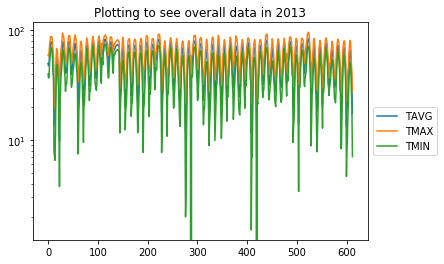

In [21]:
#Plotting to see overall data in 2013

plot1=df_data_temperature.plot(logy=True, title='Plotting to see overall data in 2013')
plot1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plot1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fancybox=True, shadow=True, ncol=5)
plt.show

### Merging NOAA and EIA Sample data sets

In [42]:
file='ISO3166.csv' #file with US ISO3166 codes
df_iso3166 = pd.read_csv(file,sep=',')
df_iso3166.head()

,iso3166,state
0,US-AL,Alabama
1,US-AK,Alaska
2,US-AZ,Arizona
3,US-AR,Arkansas
4,US-CA,California


In [43]:

df_iso3166['iso3166']=df_iso3166['iso3166'].apply(lambda iso: iso[0:2]+'A'+iso[2:])
df_iso3166.head()

,iso3166,state
0,USA-AL,Alabama
1,USA-AK,Alaska
2,USA-AZ,Arizona
3,USA-AR,Arkansas
4,USA-CA,California


In [44]:
#Adding the quivalent iso3166 code to the table
df_data_temperature['iso3166']=''


for iso in df_iso3166.values:
    df_index=df_data_temperature[df_data_temperature['state']==iso[1]]['iso3166'].index
    df_data_temperature.iloc[df_index,5]=iso[0]

#getting date in proper format
df_data_temperature['date2']=pd.to_datetime(df_data_temperature['date'] )
df_data_temperature.head()


datatype,date,TAVG,TMAX,TMIN,state,iso3166,date2
0,2013-01-01T00:00:00,49.604348,59.304310,39.854783,Alabama,USA-AL,2013-01-01
1,2013-02-01T00:00:00,47.433913,58.216379,36.712069,Alabama,USA-AL,2013-02-01
2,2013-03-01T00:00:00,49.392793,61.686842,37.068468,Alabama,USA-AL,2013-03-01
3,2013-04-01T00:00:00,62.018966,73.966379,50.066379,Alabama,USA-AL,2013-04-01
4,2013-05-01T00:00:00,67.977477,79.181982,56.775676,Alabama,USA-AL,2013-05-01


In [45]:
#getting date in proper format
df_data['date2']=df_data['date'].apply(lambda dt:'{:%Y-%m-%d}'.format(datetime(int(dt[0:4]), int(dt[4:6]), 1)))
df_data.head()

,date,geography,iso3166,Net generation,unit_x,Retail sales of electricity,unit_y,Revenue from retail sales of electricity,unit_x,Average retail price of electricity,unit_y,Number of customer accounts,unit,date2
0,201312,USA-AK,USA-AK,649.50352,thousand megawatthours,602.36499,million kilowatthours,103.67788,million dollars,17.21,cents per kilowatthour,328186,number of customers,2013-12-01
1,201311,USA-AK,USA-AK,564.70533,thousand megawatthours,526.26297,million kilowatthours,89.28706,million dollars,16.97,cents per kilowatthour,328614,number of customers,2013-11-01
2,201310,USA-AK,USA-AK,568.77441,thousand megawatthours,504.66318,million kilowatthours,82.52414,million dollars,16.35,cents per kilowatthour,329670,number of customers,2013-10-01
3,201309,USA-AK,USA-AK,503.93265,thousand megawatthours,487.79956,million kilowatthours,78.83753,million dollars,16.16,cents per kilowatthour,329133,number of customers,2013-09-01
4,201308,USA-AK,USA-AK,499.43930,thousand megawatthours,503.01620,million kilowatthours,81.24433,million dollars,16.15,cents per kilowatthour,328807,number of customers,2013-08-01


In [28]:
#Getting the data in a single view
df_data_all=df_data.merge(df_data_temperature, how='outer', left_on=['iso3166', 'date2'], right_on=['iso3166', 'date2'])
df_data_all

ValueError: You are trying to merge on object and datetime64[ns] columns. If you wish to proceed you should use pd.concat